# Intro

<img width=600 src="images/wine.jpg">
<p>This notebook demonstrates solving a classification problem on the example of the <a href="https://archive.ics.uci.edu/ml/datasets/Wine">Wine Data Set</a>. The dataset containes chemical analysis of wines from three different cultivars. We will train models that will be able to predict to which cultivar does a certain wine belong.</p>

# Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

import sys
sys.path.insert(0, "..")
import mymllib

%matplotlib inline
sns.set(font_scale=1.2)

PALETTE = "deep"

# Exploratory data analysis

## Download the dataset

In [2]:
columns = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium",
           "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins",
           "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
dataset = pd.read_table(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",
    names=columns, sep=",", na_values = "?")
dataset.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Check the dataset for missing data

As we can see, there is no missing values in the dataset:

In [3]:
dataset.isna().sum()

Class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

## Select features and target

We select the Class column as the target value and all other columns as features:

In [4]:
target_column = columns[0]
feature_columns = columns[1:]

print("Target:", target_column)
print("Features:", feature_columns)

Target: Class
Features: ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']


## Train/Test split

Here we use a simple 80%/20% train/test split:

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=123)
test_dataset = dataset.drop(train_dataset.index)
print("Train dataset size:", train_dataset.shape[0])
print("Test dataset size:", train_dataset.shape[1])

Train dataset size: 142
Test dataset size: 14


## Classes examples count

Let's compare number of examples of each class:

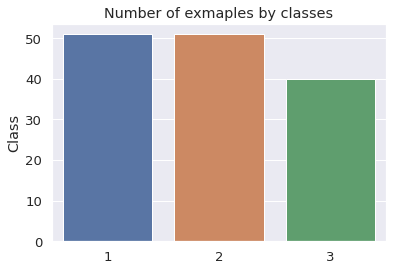

In [6]:
class_counts = train_dataset[target_column].value_counts()
plt.title("Number of exmaples by classes")
_ = sns.barplot(class_counts.index, class_counts, palette=PALETTE)

As we can see from the plot, classes have different number of examples and thus the dataset is not stricktly balanced. However difference between the classes is not too big and shouldn't cause any significant problems.

## Visualization with PCA

To visualize the data, its dimensionality should be reduced to 2 dimension, which can be achieved with PCA. For PCA to work properly the data should be normalized:

In [7]:
data_scaler = mymllib.preprocessing.DataScaler().fit(train_dataset[feature_columns])
normalized_features = data_scaler.scale(train_dataset[feature_columns], by_std=False)

Let's run PCA. As we can see, the retained variance of two principal components is equal to 99.98% which makes them a great represantation of the data:

In [8]:
pca = mymllib.dim_reduction.PCA(2).fit(normalized_features)
print("Retained variance:", sum(pca.retained_variance))
features_2D = pca.transform(normalized_features)

Retained variance: 0.9998390273646086


Now when we have a 2D representation of our data we can plot it and check how examples of different classes are located with respect to each other:

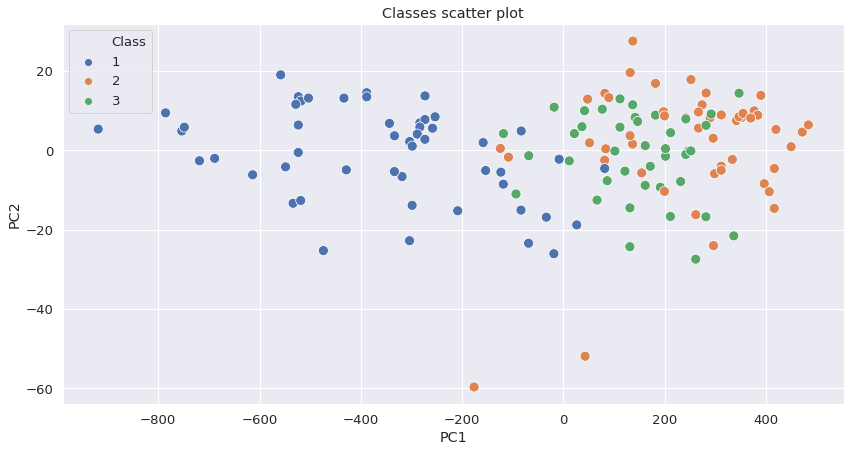

In [9]:
plt.figure(figsize=(14, 7))
plt.title("Classes scatter plot")
sns.scatterplot(x=features_2D[:, 0], y=features_2D[:, 1],
                hue=train_dataset[target_column], legend="full", palette=PALETTE,
                s=100)
plt.xlabel("PC1")
_ = plt.ylabel("PC2")

The scatter plot shows that examples from different classes are not linearly separable, which means that a model would need to learn a nonlinear function to perform better on this dataset. We will try out two models that are capable of doing this: a logistic regression with polynomial features and a neural network with a hidden layer.

# Models

## Features/target split

We split both train and test datasets into X (features) and y (target) to make them suitable for training and testing models:

In [10]:
X_train = train_dataset[feature_columns]
y_train = train_dataset[target_column]

X_test = test_dataset[feature_columns]
y_test = test_dataset[target_column]

## Logistic regression

As were shown above, examples of different classes are not linearly separable and thus for logistic regression to better classify them them we need to create polynomial features:

In [11]:
X_train_poly = mymllib.preprocessing.add_polynomial(X_train, 2)
X_test_poly = mymllib.preprocessing.add_polynomial(X_test, 2)

We also normalize the data so that all features would have a mean of 0 and a variance of 1:

In [12]:
data_scaler = mymllib.preprocessing.DataScaler().fit(X_train_poly)
X_train_norm = data_scaler.scale(X_train_poly)
X_test_norm = data_scaler.scale(X_test_poly)

Now we can train the model:

In [13]:
logistic_regression = mymllib.regression.LogisticRegression(
    regularization_param=0.1)
logistic_regression.fit(X_train_norm, y_train)

Lets test the model's performance both on train and test sets. Mean absolute error (MAE) and mean absolute percentage error (MAPE) are used as metrics:

In [14]:
import mymllib.metrics.classification as metrics

def test_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("Train F1 score:", metrics.f1_score(
        y_train, y_train_pred))
    print("Test F1 score::", metrics.f1_score(
        y_test, y_test_pred))

test_model(logistic_regression, X_train_norm, y_train, X_test_norm, y_test)

Train F1 score: 1.0
Test F1 score:: 0.9726830903301491


## Neural network

We will use a neural network with a hidden layer to capture non-linear dependencies, so we can skip creating polynomial features and just perform normalization:

In [15]:
data_scaler = mymllib.preprocessing.DataScaler().fit(X_train)
X_train_norm = data_scaler.scale(X_train)
X_test_norm = data_scaler.scale(X_test)

Here we train and test a feed-forward fully-connected neural network with a single hidden layer:

In [16]:
neural_net = mymllib.neural_networks.ClassificationNeuralNetwork(
    hidden_layers=(7,),
    regularization_param=0.1)
neural_net.fit(X_train_norm, y_train)
test_model(neural_net, X_train_norm, y_train, X_test_norm, y_test)

Train F1 score: 1.0
Test F1 score:: 0.9726830903301491
